In [201]:
%reload_ext autoreload
%autoreload 2
import bmxobs
from bmxobs.SingleFreqGeometry import SingleFreqGeometry
from bmxobs.TheoryPredictor import TheoryPredictor
import fitsio
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import j1
import copy

In [99]:
bmxobs.__path__

['/direct/astro+u/wcook/bmxobs/bmxobs']

In [19]:
D=bmxobs.BMXSingleFreqObs("pas/210802_0200")

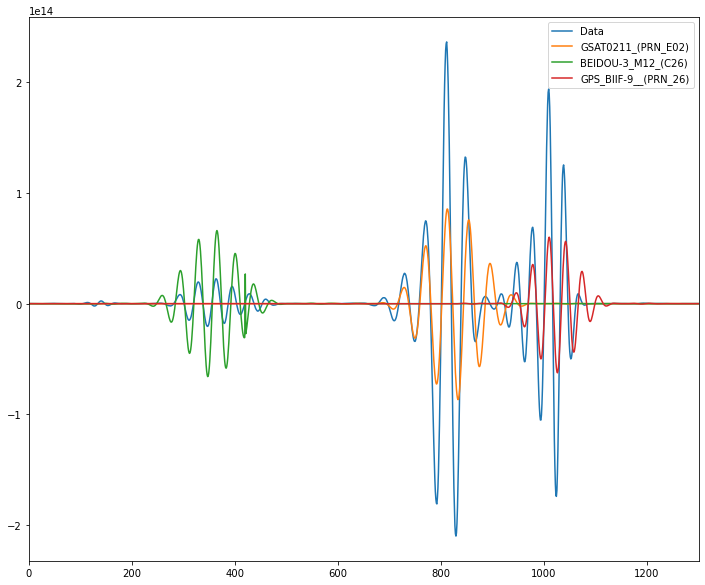

In [126]:
cut = [0,1300]

plt.figure(figsize=(12,10))
plt.plot(D[23].real[cut[0]:cut[1]],label='Data')

for n,s in zip(D.sat_id,D.sat):
    if "COS" not in n:
        #dx= np.exp(-np.cos(s['alt'])**2/(2*0.05**2))
        track = np.array([np.cos(s['alt'])*np.cos(s['az']),np.cos(s['alt'])*np.sin(s['az'])]).T
        dx = SingleFreqGeometry().point_source(23,1,track).real
        if max(dx[cut[0]:cut[1]])>0.2:
            plt.plot(dx*1e14,label=n)
        
plt.xlim(cut[0],cut[1])
plt.legend()
plt.show()

['A_GPS_BIII-4__(PRN_14)', 'A_GSAT0103_(PRN_E19)', 'A_GPS_BIIF-11_(PRN_10)', 'A_GSAT0211_(PRN_E02)', 'A_GPS_BIIRM-4_(PRN_15)', 'A_GSAT0220_(PRN_E13)', 'A_BEIDOU-3_M20', 'A_BEIDOU-3_M12_(C26)', 'A_BEIDOU-3_M3_(C27)', 'A_GSAT0209_(PRN_E09)', 'A_GPS_BIIF-9__(PRN_26)', 'A_BEIDOU-3_M15_(C34)', 'A_BEIDOU-3_M10_(C24)', 'A_GPS_BIIR-8__(PRN_16)', 'A_GPS_BIIF-10_(PRN_08)', 'A_GSAT0205_(PRN_E24)', 'A_GPS_BIIR-4__(PRN_20)', 'A_BEIDOU_15_(C14)', 'A_GSAT0104_(PRN_E20)', 'A_BEIDOU-3_M1_(C19)', 'A_GSAT0222_(PRN_E33)', 'A_GPS_BIII-3__(PRN_23)', 'A_BEIDOU-3_M23_(C45)', 'A_GSAT0202_(PRN_E14)', 'A_GSAT0217_(PRN_E27)', 'A_GSAT0208_(PRN_E08)', 'A_BEIDOU-3_M18_(C37)', 'A_BEIDOU-3_M5_(C21)', 'A_GSAT0212_(PRN_E03)', 'A_GSAT0215_(PRN_E21)', 'A_BEIDOU_19_(C58)', 'A_GPS_BIIRM-8_(PRN_05)', 'A_GPS_BIIRM-6_(PRN_07)', 'A_BEIDOU-3_M7_(C29)', 'A_GSAT0102_(PRN_E12)', 'A_GPS_BIIRM-2_(PRN_31)', 'A_BEIDOU-3_M11_(C25)', 'A_GPS_BIII-2__(PRN_18)', 'A_GSAT0218_(PRN_E31)', 'A_BEIDOU-3_M8_(C30)', 'A_BEIDOU-3_M19', 'A_GPS_BIIF-6_

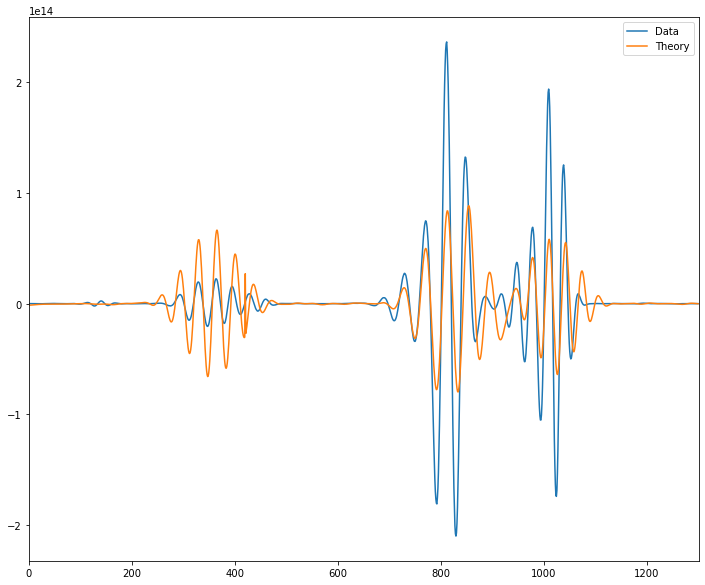

In [207]:
cut = [0,1300]

plt.figure(figsize=(12,10))
plt.plot(D[23].real[cut[0]:cut[1]],label='Data')

theory = TheoryPredictor(D)
print(theory.allParameters())
plt.plot(theory.output(23).real[0:1300]*1e14,label='Theory')

plt.xlim(cut[0],cut[1])
plt.legend()
plt.show()